# Description
### This notebook is designed to show uses of formal_tests.py, a script designed to present some robust information regarding the barotropic model. For example, understanding the required number of ensemble members to sample the forcing, and finding the zonally symmetric climatological variance caused by the forcing.

### 1.1 Import packages

In [1]:
%matplotlib notebook
from forced_barotropic_sphere.sphere import Sphere
from forced_barotropic_sphere.solver import Solver
from forced_barotropic_sphere.forcing import Forcing
import forced_barotropic_sphere.formal_tests as ft
#import bm_methods.bm_methods
import xarray as xr
import forced_barotropic_sphere.plotting as plotters
import forced_barotropic_sphere.ensemble_methods as ensemble_methods
import numpy as np
import random
import matplotlib.pyplot as plt    
import matplotlib.animation as manim
import matplotlib.ticker as mticker
from IPython.display import display, clear_output, HTML, FileLink  # Some technical stuff, used to display animation
#from ipywidgets import FloatProgress
from ipykernel.pylab.backend_inline import flush_figures
import cartopy                   # Map projection stuff
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy.ndimage import gaussian_filter1d as gf1d

d2s=86400

/home/bertossa/miniconda3/envs/jupyter/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### 1.1 Check how many members are needed to sample forcing well

In [3]:
dt = 4000 #time between integration steps (seconds)
nlat=64; nlon=128

num_members= 500 #max num of members in the ensemble
fcli,fens=ft.ensemble_forcing_sampling(nlat,nlon,dt,n_ens=num_members)

100%|█████████████████████████████████████████| 500/500 [00:06<00:00, 73.78it/s]


<IPython.core.display.Javascript object>


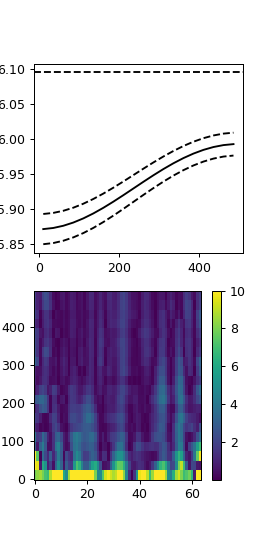

In [4]:
fig,axs = plt.subplots(2,1,figsize=(3,6))
yy=15

clim = fcli.std(axis=0).mean(axis=-1)

x=range(10,num_members,25)
mu = np.array([ fens[:n,:-1,yy,:].std(axis=0).mean(axis=-1).mean(axis=0) for n in x ])
sig =np.array([ fens[:n,:-1,yy,:].std(axis=0).mean(axis=-1).std(axis=0) for n in x ])
axs[0].plot(x, gf1d(mu, sigma=10), color = 'k')
axs[0].plot(x, gf1d(mu+sig, sigma=10), color = 'k',linestyle='--')
axs[0].plot(x, gf1d(mu-sig, sigma=10), color = 'k',linestyle='--')
axs[0].axhline(clim[yy] ,linestyle='--',color='k')


ss= np.empty((len(x),fens.shape[2]))
for i,n in enumerate(x):
    ss[i]=fens[:n,:-1,:,:].std(axis=0).mean(axis=(0,-1))
    
cf= axs[1].pcolormesh(range(nlat),x, abs(clim-ss)/clim*100., vmax=10)

plt.colorbar(cf,ax=axs[1])
plt.show()

### 1.2 Derive Climatological Spread

integrating for  27.962962962962962  days, with a dt of  0.046296296296296294  days


100%|█████████████████████████████████████████| 500/500 [16:05<00:00,  1.93s/it]


<IPython.core.display.Javascript object>


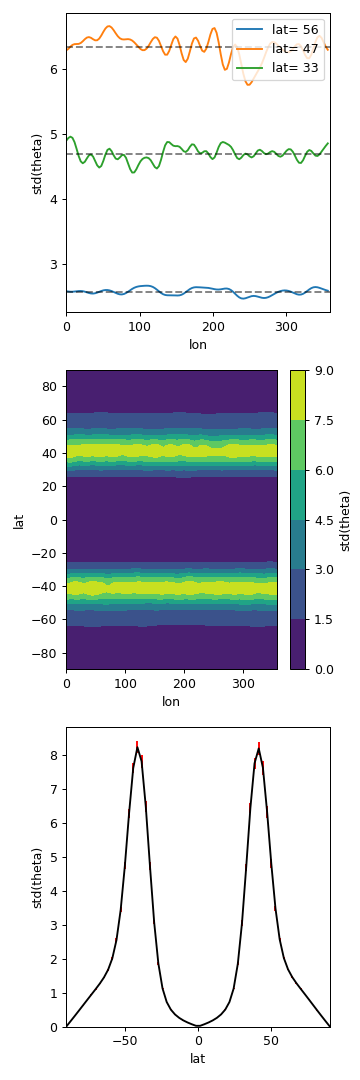

In [2]:
dt = 4000 #time between integration steps (seconds)
nlat=64; nlon=128

clim= ft.climatological_spread(nlat,nlon,dt,5e-12,True)

In [5]:
clim

<xarray.Dataset>
Dimensions:  (y: 64, x: 128, runs: 10)
Coordinates:
  * y        (y) float64 90.0 87.14 84.29 81.43 ... -81.43 -84.29 -87.14 -90.0
  * x        (x) float64 0.0 2.812 5.625 8.438 11.25 ... 348.8 351.6 354.4 357.2
Dimensions without coordinates: runs
Data variables:
    vort     (runs, y, x) float64 1.842e-17 1.842e-17 ... 1.651e-17 1.651e-17
    vortp    (runs, y, x) float64 1.842e-17 1.842e-17 ... 1.651e-17 1.651e-17
    u        (runs, y, x) float64 0.2895 0.3153 0.3407 ... 0.3194 0.3216 0.3243
    v        (runs, y, x) float64 0.5712 0.5573 0.5422 ... 0.4166 0.4149 0.4128
    thetap   (runs, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    theta    (runs, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [3]:
clim.to_netcdf('../climatology.nc')

### 1.3 Check to see how long it takes for ensemble to approach climatology

In [ ]:
num_members= 250 #num of members in the ensemble
dt = 4000 #time between integration steps (seconds)
Nt = 750 #number of integration steps
T= d2s*6*7 #total integration time
nlat=64; nlon=128

ofreq=3

thetap = np.zeros((nlat,nlon))
vortp = np.zeros((nlat,nlon))

ics = np.array([vortp,thetap])


ensemble = ensemble_methods.integrate_ensemble(nlat,nlon,dt=dt, T=T, ofreq=ofreq, ics=ics,
                                               forcing_type='red_eddy', n_ens=num_members, temp_linear=True,
                                               vort_linear=True, vortpert=0.)

tidx=int(Nt/ofreq)-1

clims= xr.open_dataset('../climatology.nc')#.mean('x')


 44%|██████████████████▏                      | 111/250 [05:01<06:15,  2.70s/it]

In [ ]:
s2d = 1/60./60./24.
fig = plt.figure(figsize=(8,8))
proj=ccrs.NorthPolarStereo()
xy=(105,40)

levels = [np.linspace(0,8,5), np.linspace(0,10,5)*0.1]

VOI = ['theta','vortp'] #variables of interest

jj = 1
for i,var in enumerate(VOI):
    print(var)
    ax1 = plt.subplot(3,len(VOI),jj, projection = proj) #axes for map
    ax2 = plt.subplot(3,len(VOI),jj+2)
    ax3 = plt.subplot(3,len(VOI),jj+4) #axes for discrete point
    
    
    #plot 1
    if i==0:
        plotters.plot_theta_ensspread(ensemble.isel(time=tidx), ax=ax1, levels=levels[i])
    else:
        plotters.plot_zeta_ensspread(ensemble.isel(time=tidx), ax=ax1, levels=levels[i])
    
    ax1.scatter(x=xy[0], y=xy[1], color='r', transform = ccrs.PlateCarree())
    
    
    ens_point = ensemble[var].sel(x=xy[0], y=xy[1], method='nearest')
    
    #plot 2
    ax2.plot(ensemble.time*s2d, ens_point.T, color='grey', alpha=0.1)
    ax2.plot(ensemble.time*s2d, ens_point.mean('ens_mem'), color='k')
    ax2.plot(ensemble.time*s2d, ens_point.mean('ens_mem') +ens_point.std('ens_mem'),
             color='tab:blue',linestyle='--')
    ax2.plot(ensemble.time*s2d, ens_point.mean('ens_mem') -ens_point.std('ens_mem'),
             color='tab:blue',linestyle='--', label = '1 std')
    ax2.plot(ensemble.time*s2d,ens_point.mean('ens_mem').values+clims[var].sel(y=xy[1], method='nearest').mean('x').values, 
                color = 'r', linestyle = '--', label='climatology')
    ax2.plot(ensemble.time*s2d,ens_point.mean('ens_mem').values-clims[var].sel(y=xy[1], method='nearest').mean('x').values,
                color = 'r', linestyle = '--')
    
    #plot 3
    ax3.plot(ensemble.time*s2d, ens_point.std('ens_mem'), label = 'ensemble')
    ax3.axhline(clims[var].sel(y=xy[1], method='nearest').max('x').values,0,1, color = 'r', linestyle = '--', 
               label='climatology')
    ax3.axhline(clims[var].sel(y=xy[1], method='nearest').min('x').values,0,1, color = 'r', linestyle = '--')


    ax2.yaxis.tick_right()
    ax3.set_xlabel('time (days)')
    ax3.set_ylabel("std({})".format(var))
    ax2.set_ylabel(var)
    ax2.set_xlim(0.,T*s2d)
    ax3.set_xlim(0.,T*s2d)
    ax3.legend()
    ax2.legend()
    jj+=1
#plt.tight_layout()
plt.show()


#     ax4.yaxis.tick_right()
#     ax4.set_xlabel('time (days)')
#     ax4.set_ylabel(r'Zeta (s$^{-1}$)')
#     ax4.yaxis.set_label_position("right")

In [31]:
ensemble['theta'].sel(x=xy[0], y=xy[1], method='nearest').isel(time=187).argmax()

<xarray.DataArray 'theta' ()>
array(183)
Coordinates:
    time     float64 1.5e+06
    y        float64 41.43
    x        float64 84.38

In [32]:
ensemble

<xarray.Dataset>
Dimensions:  (time: 188, y: 64, x: 128, ens_mem: 500)
Coordinates:
  * time     (time) float64 0.0 8.021e+03 1.604e+04 ... 1.492e+06 1.5e+06
  * y        (y) float64 90.0 87.14 84.29 81.43 ... -81.43 -84.29 -87.14 -90.0
  * x        (x) float64 0.0 2.812 5.625 8.438 11.25 ... 348.8 351.6 354.4 357.2
Dimensions without coordinates: ens_mem
Data variables:
    vort     (ens_mem, time, y, x) float64 0.0 0.0 0.0 ... 2.36e-16 2.36e-16
    vortp    (ens_mem, time, y, x) float64 0.0 0.0 0.0 ... 2.36e-16 2.36e-16
    u        (ens_mem, time, y, x) float64 0.0 0.0 0.0 ... -0.3589 -0.2717
    v        (ens_mem, time, y, x) float64 -0.0 -0.0 -0.0 ... -1.767 -1.783
    thetap   (ens_mem, time, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    theta    (ens_mem, time, y, x) float64 255.0 255.0 255.0 ... 255.0 255.0

<IPython.core.display.Javascript object>


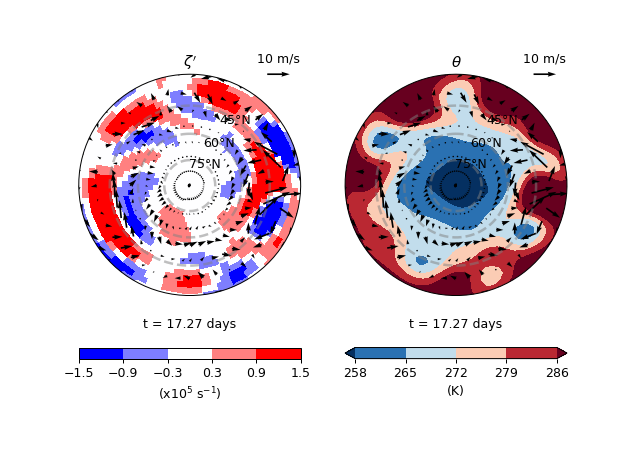

In [35]:
f,ax = plotters.plot_overview(ensemble.isel(time=186).isel(ens_mem=183), levels=[np.linspace(-1.5,1.5,6),np.arange(258,293,7)], perturbation=[True,False])